<a href="https://colab.research.google.com/github/GrigoryBartosh/hse08_ip/blob/master/hw3_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
cd 'drive/My Drive/ip_hw_3'

/content/drive/My Drive/ip_hw_3


In [0]:
! pip install wandb >> /dev/null

In [0]:
import os
import copy
import zipfile
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import models

from PIL import Image

import wandb

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.cm as cm

PATH_DATA = 'tl-signs-hse-itmo-2020-winter.zip'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32
LR = 0.001
W_L2 = 0
EPOCHS1 = 35
EPOCHS2 = 35

In [23]:
xs, ys = [], []
with zipfile.ZipFile(PATH_DATA, 'r') as zip_file:
    with zip_file.open('train.csv') as file:
        train_data = pd.read_csv(file)

    for _, x in tqdm(train_data.iterrows()):
        name, lable = x['filename'], x['class_number']
        with zip_file.open(os.path.join('train', 'train', name)) as img_file:
            image = Image.open(img_file).convert('RGB')
        xs += [image]
        ys += [lable]

num_classes = max(ys) + 1

x_train, x_val, y_train, y_val = train_test_split(xs, ys, test_size=0.1)

In [0]:
class SiamDataset(data.Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys

    def __getitem__(self, index):
        x = self.xs[index]
        y = self.ys[index]

        x = torch.FloatTensor(np.array(x))
        y = torch.LongTensor([y])

        return x, y

    def __len__(self):
        return len(self.xs)

In [0]:
def collate_xs(xs):
    xs = torch.stack(xs, axis=0)
    xs = xs * 2 / 255 - 1
    xs = xs.permute(0, 3, 1, 2)

    return xs

def collate_fn(data):
    xs, ys = zip(*data)
    
    xs = collate_xs(xs)
    ys = torch.cat(ys)

    return xs, ys

train_dataset = SiamDataset(x_train, y_train)
val_dataset = SiamDataset(x_val, y_val)

train_data_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)

In [0]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    return nn.Conv2d(in_planes, out_planes, 3, 
                     stride, padding, bias=False)
    

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, 1, 
                     stride, padding=0, bias=False)


class SimpleBlock(nn.Module):
    def __init__(self, in_planes, out_planes=None, stride=1):
        super(SimpleBlock, self).__init__()

        if out_planes is None:
            out_planes = in_planes

        self.activ = nn.ReLU()

        self.conv1 = conv3x3(in_planes, out_planes, stride)
        self.ln1 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.ln1(out)
        out = self.activ(out)

        return out


class ResBasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes=None, stride=1):
        super(ResBasicBlock, self).__init__()

        planes = in_planes

        if out_planes is None:
            out_planes = planes

        self.residual_conv = None
        if stride != 1 or in_planes != out_planes:
            self.residual_conv = conv1x1(in_planes, out_planes, stride)
            self.residual_ln = nn.BatchNorm2d(out_planes)

        self.activ = nn.ReLU()

        self.conv1 = conv3x3(in_planes, planes, stride)
        self.ln1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, out_planes)
        self.ln2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.ln1(out)
        out = self.activ(out)

        out = self.conv2(out)
        out = self.ln2(out)

        if self.residual_conv is not None:
            identity = self.residual_conv(identity)
            identity = self.residual_ln(identity)

        out += identity
        out = self.activ(out)

        return out


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        in_dim = 8
        #self.embed_dim = in_dim * 2 ** 4
        self.embed_dim = 2

        self.model = [SimpleBlock(3, in_dim, 2)]
        for _ in range(3):
            self.model += [SimpleBlock(in_dim, in_dim * 2, 2)]
            in_dim = in_dim * 2
        self.model += [conv3x3(in_dim, self.embed_dim, padding=0)]

        self.model = nn.Sequential(*self.model)
                 
    def forward(self, x):
        x = self.model(x)
        x = x.squeeze()
        return x


class AnsambleModel(nn.Module):
    def __init__(self, n):
        super(AnsambleModel, self).__init__()

        self.models = nn.ModuleList([FeatureExtractor() for _ in range(n)])

    def forward(self, x):
        x = [m(x) for m in self.models]
        x = torch.stack(x, axis=0)
        return x

In [0]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0, p=2, hard=False):
        super(TripletLoss, self).__init__()

        self.margin = margin
        self.dist_f = nn.PairwiseDistance(p=p)
        self.hard = hard

    def get_scores(self, xs):
        bs, dim = xs.shape
        xs1 = xs[:, None, :].expand(bs, bs, dim).reshape(-1, dim)
        xs2 = xs[None, :, :].expand(bs, bs, dim).reshape(-1, dim)
        scores = self.dist_f(xs1, xs2).reshape(bs, bs)
        return scores

    def get_match_class(self, ys):
        bs = ys.shape[0]
        ys1 = ys[:, None].expand(bs, bs)
        ys2 = ys[None, :].expand(bs, bs)
        return ys1 == ys2

    def self.get_pair_losses(self, pos_scores, neg_scores):
        bs = pos_scores.shape[0]
        pos_scores = pos_scores[:, :, None].expand(bs, bs, bs)
        neg_scores = neg_scores[:, None, :].expand(bs, bs, bs)
        pair_losses = torch.max(pos_scores - neg_scores + self.margin,
                                torch.zeros_like(pos_scores))

    def forward(self, xs, ys):
        scores = self.get_scores(xs)
        match_class = self.get_match_class(ys)

        pos_scores = scores * match_class - \
                     (scores.max() + self.margin) * (~match_class)
        neg_scores = scores * (~match_class) + \
                     (scores.max() + self.margin) * match_class

        pair_losses = self.get_pair_losses(pos_scores, neg_scores)
        pair_losses = pair_losses.


        return loss


class AnsableTripletLoss(nn.Module):
    def __init__(self, margin=1.0, p=2, hard=False):
        super(AnsableTripletLoss, self).__init__()

        self.criterion = TripletLoss(margin, p, hard)

    def forward(self, xs, ys):
        losses = []
        for x in xs:
            losses += [self.criterion(x, ys)]
        losses = torch.stack(losses)
        loss = losses.sum()
        return loss

In [0]:
def train(model, criterion, optimizer, scheduler, epochs):
    wandb.init(project="hse08_ip_hw_3")

    best_model = copy.deepcopy(model)
    best_loss = 10 ** 10
    for _ in trange(epochs):
        for xs, ys in train_data_loader:
            xs = xs.to(device)
            ys = ys.to(device)
            
            optimizer.zero_grad()

            outputs = model(xs)
            loss = criterion(outputs, ys)

            wandb.log({'Train loss': loss.item()})

            loss.backward()
            optimizer.step()

        losses = []
        model.eval()
        with torch.no_grad():
            for xs, ys in val_data_loader:
                xs = xs.to(device)
                ys = ys.to(device)

                outputs = model(xs)
                loss = criterion(outputs, ys)
                
                losses += [loss.item()]
            
        model.train()

        loss = np.array(losses).mean()
        wandb.log({'Val loss': loss})
        
        if best_loss > loss:
            best_loss = loss
            best_model = copy.deepcopy(model)
        
        if scheduler:
            scheduler.step()

    return best_model

In [0]:
def get_centroids_for_one(model, xs, ys):
    centroids_sum = np.zeros((max(ys) + 1, model.embed_dim))
    cnts_sum = np.zeros((max(ys) + 1))

    with torch.no_grad():
        for i in range(0, len(xs), BATCH_SIZE):
            j = min(i + BATCH_SIZE, len(xs))
            batch_xs, batch_ys = xs[i:j], ys[i:j]

            batch_xs = [torch.FloatTensor(np.array(x)) for x in batch_xs]
            batch_xs = collate_xs(batch_xs)
            batch_xs = batch_xs.to(device)

            features = model(batch_xs).cpu().numpy()
            for f, y in zip(features, batch_ys):
                centroids_sum[y] += f
                cnts_sum[y] += 1

    cnts_sum = np.repeat(np.expand_dims(cnts_sum, axis=1), 
                         model.embed_dim, axis=1)
    return centroids_sum / cnts_sum

def get_centroids(model, xs, ys):
    centroids = [get_centroids_for_one(m, xs, ys) for m in model.models]
    centroids = np.stack(centroids, axis=0)
    return centroids

In [0]:
def get_scores_for_one(model, centroids, x):
    scores_sum = [0] * (max(ys) + 1)
    cnts_sum = [0] * (max(ys) + 1)

    with torch.no_grad():
        x = [torch.FloatTensor(np.array(x))]
        x = collate_xs(x)
        x = x.to(device)

        x = model(x).cpu().numpy()

    x = np.repeat(np.expand_dims(x, axis=0), len(centroids), axis=0)
    scores = ((centroids - x) ** 2).sum(axis=1)

    return scores

def get_scores(model, centroids, x):
    scores = [get_scores_for_one(m, c, x) 
              for m, c, in zip(model.models, centroids)]
    scores = np.stack(scores, axis=0)
    return scores

In [0]:
def get_predictions(scores):
    #ys = scores.mean(axis=1).argmin(axis=1)

    ys = scores.argmin(axis=2)
    ys = [np.bincount(y).argmax() for y in ys]
    ys = np.stack(ys, axis=0)

    return ys

In [0]:
def get_nn_accuracy(scores, ys):
    ys_predicted = get_predictions(scores)
    return (ys_predicted == ys).sum() / len(ys)

In [0]:
def draw(model, xs, ys):
    colors = cm.rainbow(np.linspace(0, 1, max(ys) + 1))

    with torch.no_grad():
        for i in range(0, len(xs), BATCH_SIZE):
            j = min(i + BATCH_SIZE, len(xs))
            batch_xs, batch_ys = xs[i:j], ys[i:j]

            batch_xs = [torch.FloatTensor(np.array(x)) for x in batch_xs]
            batch_xs = collate_xs(batch_xs)
            batch_xs = batch_xs.to(device)

            features = model(batch_xs).cpu().numpy()
            for f, y in zip(features, batch_ys):
                plt.plot(f[0], f[1], 'ro', color=colors[y])

    plt.show()

In [34]:
n = 1

nn_model = AnsambleModel(n=n)
nn_model.to(device)

criterion = AnsableTripletLoss(margin=10.0, p=2, hard=False)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, nn_model.parameters()), 
                       LR, weight_decay=W_L2)

nn_model.train()
nn_model = train(nn_model, criterion, optimizer, None, 30)

Exception in thread Thread-59:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/watchdog/observers/api.py", line 196, in run
    self.dispatch_events(self.event_queue, self.timeout)
  File "/usr/local/lib/python3.6/dist-packages/watchdog/observers/api.py", line 369, in dispatch_events
    handler.dispatch(event)
  File "/usr/local/lib/python3.6/dist-packages/watchdog/events.py", line 452, in dispatch
    super(PatternMatchingEventHandler, self).dispatch(event)
  File "/usr/local/lib/python3.6/dist-packages/watchdog/events.py", line 336, in dispatch
    }[event.event_type](event)
  File "/usr/local/lib/python3.6/dist-packages/wandb/run_manager.py", line 693, in _on_file_modified
    self._get_file_event_handler(event.src_path, save_name).on_modified()
  File "/usr/local/lib/python3.6/dist-packages/wandb/run_manager.py", line 298, in on_modified
    self._api.get_file_s

In [44]:
criterion = AnsableTripletLoss(margin=10.0, p=2, hard=True)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, nn_model.parameters()), 
                       0.0001, weight_decay=W_L2)

nn_model = train(nn_model, criterion, optimizer, None, 30)

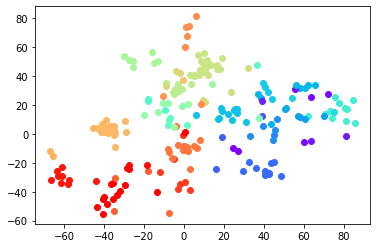

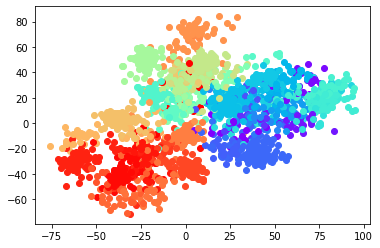

In [45]:
draw(nn_model.models[0], x_train[::100], y_train[::100])
draw(nn_model.models[0], x_val, y_val)

In [36]:
nn_model.eval()

centroids = get_centroids(nn_model, x_train, y_train)

train_scores = [get_scores(nn_model, centroids, x) for x in tqdm(x_train)]
val_scores = [get_scores(nn_model, centroids, x) for x in tqdm(x_val)]
train_scores = np.stack(train_scores, axis=0)
val_scores = np.stack(val_scores, axis=0)

train_nn_accuracy = get_nn_accuracy(train_scores, y_train)
val_nn_accuracy = get_nn_accuracy(val_scores, y_val)

print(f'Train NN accuracy {train_nn_accuracy}')
print(f'Val NN accuracy {val_nn_accuracy}')


Train NN accuracy 0.16047710590702552
Val NN accuracy 0.17138364779874213


In [0]:
images = []
with zipfile.ZipFile(PATH_DATA, 'r') as zip_file:
    image_names = [f[10:] for f in zip_file.namelist() if 'test' in f]

    for name in tqdm(image_names):
        with zip_file.open(os.path.join('test', 'test', name)) as img_file:
            image = Image.open(img_file).convert('RGB')
        images += [(name, image)]

model.eval()
predictions = {'filename': [], 'class_number': []}
with torch.no_grad():
    for name, image in tqdm(images):
        x = collate_xs([image])
        x = x.to(device)

        y = model(x)[0].argmax()
        y = y.item()

        predictions['filename'] += [name]
        predictions['class_number'] += [y]

predictions = pd.DataFrame(predictions)
predictions.to_csv('test_neural.csv', index=False)